Project Proposal

Title:


Introduction:

Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
Clearly state the question you will try to answer with your project
Identify and describe the dataset that will be used to answer the question


Preliminary exploratory data analysis:

Demonstrate that the dataset can be read from the web into R 
Clean and wrangle your data into a tidy format
Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 
Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

Methods:

Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
Describe at least one way that you will visualize the results

Expected outcomes and significance:

What do you expect to find?
What impact could such findings have?
What future questions could this lead to?

In [ ]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [17]:
attrition_data<-read.csv ("https://raw.githubusercontent.com/wenshanli1231/DSCI-Group-Project/main/Employee-Attrition.csv")
attrition_data

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,⋯,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
<int>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,⋯,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,⋯,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,⋯,2,80,0,7,3,3,0,0,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,⋯,2,80,1,6,0,3,6,2,0,3
49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,⋯,4,80,0,17,3,2,9,6,0,8
34,No,Travel_Rarely,628,Research & Development,8,3,Medical,1,2068,⋯,1,80,0,6,3,4,4,3,1,2


In [19]:
attrition_data <- attrition_data |>
    select( Attrition, HourlyRate, YearsAtCompany)

attrition_data

Attrition,HourlyRate,YearsAtCompany
<chr>,<int>,<int>
Yes,94,6
No,61,10
Yes,92,0
⋮,⋮,⋮
No,87,6
No,63,9
No,82,4


In [ ]:
attrition_data <- attrition_data |>
        mutate(Attrition = as_factor(Attrition))
attrition_data

Attrition,HourlyRate,YearsAtCompany
<fct>,<dbl>,<dbl>
Yes,94,6
No,61,10
Yes,92,0
⋮,⋮,⋮
No,87,6
No,63,9
No,82,4


In [ ]:
set.seed(10)

In [20]:

attrition_split <- initial_split(attrition_data, prop = 0.75, strata = Attrition)
attrition_train <- training(attrition_split)
attrition_test <- testing(attrition_split) 

glimpse(attrition_train)
glimpse(attrition_test)

Rows: 1,101
Columns: 3
$ Attrition      <chr> "No", "No", "No", "No", "No", "No", "No", "No", "No", "…
$ HourlyRate     <int> 61, 56, 40, 79, 81, 67, 44, 94, 84, 49, 31, 93, 51, 78,…
$ YearsAtCompany <int> 10, 8, 2, 7, 1, 1, 9, 7, 5, 9, 5, 2, 10, 25, 3, 4, 12, …
Rows: 369
Columns: 3
$ Attrition      <chr> "No", "No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes…
$ HourlyRate     <int> 80, 96, 82, 58, 72, 72, 48, 37, 98, 47, 48, 51, 33, 59,…
$ YearsAtCompany <int> 6, 1, 5, 14, 10, 5, 1, 9, 1, 2, 7, 7, 5, 1, 1, 15, 5, 9…


In [21]:
attrition_recipe <- recipe(Attrition~ HourlyRate + YearsAtCompany, data = attrition_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
    
knn_spec<- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
       set_engine("kknn") |>
       set_mode("classification")

attrition_fit <- workflow() |>
       add_recipe(attrition_recipe) |>
       add_model(knn_spec) |>
       fit(data = attrition_train)
attrition_fit

ERROR: [1m[33mError[39m in `check_installs()`:[22m
[33m![39m This engine requires some package installs: 'kknn'


In [22]:
attrition_proportions <- attrition_train |>
                      group_by(Attrition) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(attrition_train))

attrition_proportions

attrition_proportions_train <- attrition_train |>
                      group_by(Attrition) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(attrition_train))

attrition_proportions_train

Attrition,n,percent
<chr>,<int>,<dbl>
No,924,83.92371
Yes,177,16.07629


Attrition,n,percent
<chr>,<int>,<dbl>
No,924,83.92371
Yes,177,16.07629


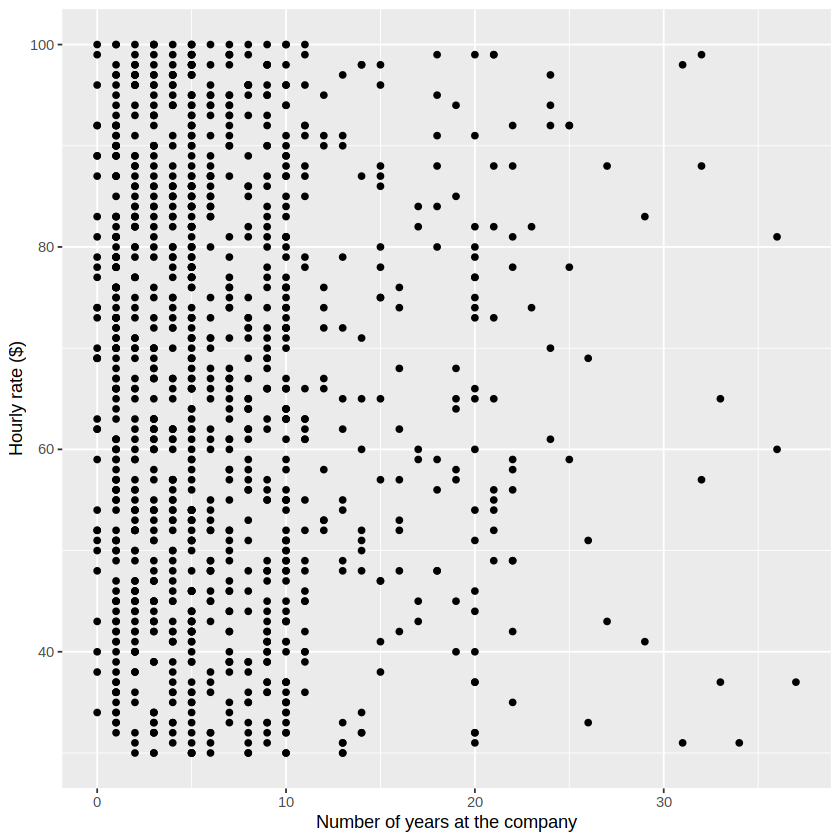

In [23]:
attrition_plot <- ggplot(attrition_train, aes(x = YearsAtCompany, y = HourlyRate)) + 
            geom_point() +
            xlab("Number of years at the company") +
            ylab("Hourly rate ($)")

attrition_plot